In [56]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# Импортируем нужные библиотеки

#### Считывание и обработка данных

In [57]:
df = pd.read_excel("200_выпусков_'О_мой_питч!'_OutOfScope_update.xlsx", sheet_name='Лист2')
df = df.rename(columns={'Инвестиции' : 'Инвестиции(руб)', 'Без' : 'Воздержалось'})
df['За'] = pd.to_numeric(df['За'], errors='coerce')
df['Против'] = pd.to_numeric(df['Против'], errors='coerce')
df['Воздержалось'] = pd.to_numeric(df['Воздержалось'], errors='coerce')
df['Инвестиции(руб)'] = df['Инвестиции(руб)'].replace(0, np.nan)
df = df.drop(columns='№')
df = df.drop(index=82) #Дропаем строку в бизнесом, о котором нет данных
df = df.drop_duplicates(subset='Название')
pd.set_option('display.max_colwidth', None)  # 150 означает ограничение на кол-во символов в колонке "Описание"


#### Основные метрики по инвестициям и голосам в опросах

In [58]:
# Форматируем вывод чисел (два знака для float, целые для int)
pd.options.display.float_format = '{:,.2f}'.format
description = df[['Инвестиции(руб)', 'За', 'Против', 'Воздержалось', 'Всего']].describe()
description['Инвестиции(руб)'] = (description['Инвестиции(руб)'] / 1_000_000).round(2)
description[['За', 'Против', 'Воздержалось', 'Всего']] = description[['За', 'Против', 'Воздержалось', 'Всего']].astype(int)
description.rename(columns={'Инвестиции(руб)': 'Инвестиции (млн, руб)'}, inplace=True)
description_selected = description.loc[['mean', '25%', '50%', '75%', 'min', 'max']]
description_renamed = description_selected.rename(index={
    'mean': 'Среднее',
    '25%': '25-й перцентиль',
    '50%': 'Медиана (50-й перцентиль)',
    '75%': '75-й перцентиль',
    'min': 'Минимум',
    'max': 'Максимум'
})
description_renamed

,"Инвестиции (млн, руб)",За,Против,Воздержалось,Всего
Среднее,54.79,149,204,134,445
25-й перцентиль,12.00,95,132,101,358
Медиана (50-й перцентиль),27.00,128,176,131,435
75-й перцентиль,45.00,184,250,155,527
Минимум,0.08,35,43,61,182
Максимум,900.00,519,535,385,735


После пересмотра стартапов, где запрашиваемые инвестиции были 0, выяснилось, что на самом деле у таких стартапов просто нет информации по запрашиваемым инвестициям, поэтому все нули были заменены на NaN.  

### Разбивка стартапов по группам

In [59]:
keywords = {
    'Telegram' : ['телеграм', 'telegram', 'бот'],
    'Взаимоотношения' : [ 'познакомиться', 'знакомств', 'отношени', 'свидани', 'коммуникаци', 'скандал'],
    'AI_помощники' : ['виртуальн', 'помощник', 'ai', 'искусственн', 'интелект', 'ии'], 
    'Маркетинг_и_реклама' : ['реклам', 'маркетинг', 'продвижение', 'целевая', 'crm', 'продажи', 'привлечен', 'инвестор'],
    'B2B' : ['b2b', 'бизнес'],
    'Медицина' : ['профилактик', 'медицин', 'врач', 'докт', 'хирург ', 'маломобильных', 'процедур','здоровь', 'вирус', 'анализы', 'психолог', 'таблет', 'больн', 'узи', 'заболевани', 'фармацевт'],
    'Образование': ['студент', 'университет', 'школ', 'образован', 'универ', 'экзамен', 'общежит', 'образован', 'английск', 'иностранн'],
    'Музыка': ['музык', 'песн', 'звук', 'аккорд', 'мелод'],
    'Спорт': ['тренировк', 'фитнес', 'физкультур', 'атлетик', 'кардио', 'нагруз', 'сорев', 'экипиров', 'упражнен'],
    'Сервисы_доставки': [ 'курьер', 'доставк', 'груз', 'логистик', 'маршрут', 'навигатор'],
    'Путешествия': ['поездк', 'туризм', 'путешеств', 'путевк', 'экскурси', 'курорт', 'проживание', 'travel'],
    'Кулинария': ['кухн', 'повар', 'еда', 'пищ', 'рецепт', 'ингредиент', 'блюд', 'еды', 'общепит', 'едой'],
    'Автомобили_и_транспорт' : ['машина', 'техобслуж', 'кузов', 'транспорт','автомобил', 'двигател', 'автовладел', 'автозапчаст'],
    'Финтех' : ['крипто', 'валюта', 'трейд', 'инвестици', 'блокчейн', 'страховани', 'кредит', 'банкинг', 'платежн'],
    'Маркетплейсы' : ['маркетплейс'],
}
def categorize(description):
    matched_categories = set()  # Используем множество для уникальных категорий
    matched_words = {category: [] for category in keywords}  # Словарь для хранения всех ключевых слов по категориям
    words_in_description = description.lower().split()  # Разбиваем описание на слова
    for category, words in keywords.items():
        for word in words_in_description:
            for keyword in words:
                if word.startswith(keyword):
                    matched_categories.add(category)
                    if keyword not in matched_words[category]:
                        matched_words[category].append(keyword)
                    break
    return ', '.join(matched_categories) if matched_categories else 'Прочее', matched_words
def categorize_with_words(description):
    categories, words = categorize(description)
    # Формируем строку из всех ключевых слов для каждой категории
    all_keywords = []
    for category in categories.split(', '):
        all_keywords.extend(words.get(category, []))
    keywords_str = ', '.join(all_keywords)
    return pd.Series([categories, keywords_str])
df[['Категория', 'Ключевые слова']] = df['Описание'].apply(categorize_with_words)

In [65]:
df[df['Категория'] == 'Маркетплейсы']

,Название,Описание,Сайт,Инвестиции(руб),За,Против,Воздержалось,Всего,Дата,Категория,Ключевые слова
145,LQD Vape app,"Маркетплейс жидкостей для электронных сигарет. Полный аналог Vivino. ТАМ $10,2B. Решаемая проблема - жидкости стоят как вино, и пока не перепробуешь десяток-другой не поймешь, какие хорошие, а какие нет. Сейчас в базе более 10к жидкостей и каждый день пользователи заносят десятки новых.\n\nLQD, в отличие от интернет-магазинов, дает объективную средневзвешанную оценку жидкости, отзывы, пропорцию вкусов, ощущения от парения - все это благодаря тому, что всю информацию в приложение заносят пользователи. В июне запускаем функционал поиска продуктов и шопов на местности. В августе - распознаватель продукта по картинке.",https://vapeapp.net/,"6,750,000.00",151,496,NaN,647,2020-09-24,Маркетплейсы,маркетплейс
186,SlideLab,"Сервис для разработки презентаций и работы с ними. Совмещает в себе эффективный редактор с фокусом на производительность рабочего процесса, облачную платформу для хранения данных и маркетплейс с профессиональными шаблонами презентаций. Сервис позволяет работать с презентациями как в приложении, так и в браузере. Данные синхронизируются в реальном времени, что позволяет, в том числе, вести коллективную разработку проектов.",https://slidelab.io/,"8,000,000.00",108,318,NaN,426,2019-12-06,Маркетплейсы,маркетплейс



Разбивка работает по принципу поиска ключевого слова (начала ключегого слова) в описании стартапа



#### Определение групп



- **Telegram** - к группе относятся стартапы, в которых основным продуктом является телеграм-бот либо сервис по работе с приложениями внутри телеграма

- **Взаимоотношения** - группа стартапов, в которых сосредоточены приложения для знакомств, семейные психологи  

- **AI_помощники** - стартапы с помощниками на искусственном интеллекте, которые выполняют самые разные задачи, от консультации по тренировкам до помощи в разработке приложений  

- **Маркетинг_и_реклама** - группа содержит стартапы, которые предоставляют различные услуги продвижения малым, средним, крупным бизнесам  
- **B2B** -  стартапы, которые помогают бизнесам развиваться (различные конструкторы, платформы и другое)  
- **Медицина** - различные девайсы для защиты здоровья, также имеются сервисы с AI, которые помогают врачам в разных областях проводить сложные операции  
- **Образование** - онлайн-школы, различные сервисы для студентов и школьников, сервисы по изучению иностранных языков
- **Музыка** - сервис цифровой дистрибуции и маркетплейс по продаже песен  
- **Спорт** - приложения, которые составляют план тренировок, фитнес-трекеры
- **Сервисы_доставки** - сервисы/приложения/боты по доставке продуктов или вещей
- **Путешествия** - cтартапы из этой группы помогают найти дом, который будет наиболее подходящим, также есть сервисы для создания персонального плана путешествий  
- **Автомобили_и_транспорт** - в эту группу попали стартапы, которые нацелены на помощь водителям, механикам, и другим людям, которые работают в сфере транспорта
- **Финтех** - в группу входят стартапы по созданию криптовалютных кошельков, серсвисы трейдинга, блокчейн, платформы-помощники по получению кредита
- **Роботы** - "роботизированные" стартапы
- **Кулинария** - сервисы для помощи приготовления еды, поиска поваров, рецептов
- **Маркетплейсы** - группа содержит стартапы, главным продуктом которых является маркетплейс, либо "программа" (бот, AI), которая помогает работать с маркетплейсом
- **Прочее** - в эту группу попали стартапы, которые не попали ни в одну из вышеперечисленных групп
   


#### Примеры случайных стартапов из каждой группы


In [66]:
def get_random_startup_by_category(df, columns_to_display):
    random_startups = []
    grouped = df.groupby('Категория') 
    for category, group in grouped:
        random_startup = group.sample(1)  
        random_startups.append(random_startup)
    result_df = pd.concat(random_startups)
    return result_df[columns_to_display]

columns_to_display = ['Название', 'Описание', 'Категория', 'Ключевые слова']
random_startups_df = get_random_startup_by_category(df, columns_to_display)
pd.set_option('display.max_rows', None)
random_startups_df

,Название,Описание,Категория,Ключевые слова
111,Сказки единорога,"Мобильный каталог авторских сказок для прочтения родителями детям по модели «читай вслух». Каждая сказка — помощник для родителей, которые обнаружили у своего ребенка трудности поведения, страхи.",AI_помощники,помощник
185,Dr. Ekman,"Карманный бот-психолог, помогающий при эмоциональных проблемах. Сервис с помощью искусственного интеллекта может помочь разобрать ваше состояние, дать советы и подобрать психотерапевта.","AI_помощники, Telegram","искусственн, бот"
17,AsiliscMed AI,"Первый медицинский ИИ для 100% контроля заболеваний, ментального благополучия и здорового старения","AI_помощники, Медицина","ии, медицин, заболевани"
42,FitMind.ai,"AI-ассистент для онлайн тренеров по фитнесу и велнесу, который помогает им качественнее отвечать на вопросы клиентов и экономить время","AI_помощники, Спорт","ai, фитнес"
197,Azura AI,"Azura AI разрабатывает сервис для поддержания и профилактики здоровья, который:\n— хранит и автоматически собирает медицинские данные пользователя, в том числе и с фитнес-трекеров,\n— предоставляет персональные рекомендации по улучшению здоровья,\n— предсказывает вероятности возникновения заболеваний.\n\nРабота сервиса основана на применении искусственного интеллекта. В команде Azure AI есть и специалисты по ИИ, и врачи.","AI_помощники, Спорт, Медицина","ai, искусственн, ии, фитнес, профилактик, здоровь, медицин, заболевани, врач"
132,ScAInet,"Система поиска утечек в сетях водоснабжения с помощью искусственного интеллекта и датчиков собственной разработки. На текущий момент до 40% воды являются безвозвратными потерями из-за износа сетей. На примере Мосводоканала в год потери составляют 20-30 млрд руб. Объём рынка подобного оборудования в России 6-7 млрд руб. Нами проведён успешный пилот в Уфаводоканал, сейчас договорились о пилоте с Мосводоканалом. Инвестиции нужны для запуска производства датчиков.","AI_помощники, Финтех","искусственн, инвестици"
164,Бизнес-среда «Наработе»,"Бизнес-среда «Наработе» это портал, который включает 6-8 основных сервисов, необходимых для организации офисной, удалённой и распределенной работы: от поиска и управления контактами и взаимоотношениями с партнёрами, клиентами и коллегами, до ведения переписки и решения вопросов автоматизации процессного и проектного управления.",B2B,бизнес
169,realtycloud,"realtycloud — сервис в сфере недвижимости. b2c: online-оценка рисков перед покупкой, сопровождение сделки и помощь в продаже. b2b: пакетное предложение оценки рисков по квартирам, попадающим в базу АН. Оценка рыночной стоимости объекта (на основе алгоритма ИИ). Идем к автоматизации работы риэлтора и уменьшению чека за услуги.","B2B, AI_помощники","b2b, ии"
89,Digi Doe,"DigiDoe — финтех-стартап в Англии, который создает новую платежную инфраструктуру, используя современные достижения в биометрии, ИИ и вычислениях, которая делает платежи быстрее, безопаснее и дешевле для B2B2C.","B2B, AI_помощники, Финтех","b2b, ии, платежн"
11,Freedom.bi,"Freedom.bi предлагает единую облачную платформу для комплексной автоматизации бизнес-процессов, включая ERP, CRM, производство, управление задачами, склад, финансы и бизнес-аналитику","B2B, Маркетинг_и_реклама","бизнес, crm"


#### Количество стартапов по категориям

In [62]:
def count_subcategory_occurrences(df, subcategories):
    categories = df['Категория'].str.split(', ', expand=True)
    categories = categories.melt(value_name='Категория').dropna()['Категория']
    results = []
    for subcategory in subcategories:
        count = categories[categories.str.contains(subcategory, case=True)].count()
        results.append((subcategory, count))
    result_df = pd.DataFrame(results, columns=['Категория', 'Количество'])
    result_df = result_df.sort_values(by='Количество', ascending=False).reset_index(drop=True)
    return result_df
subcategories_list = ['Прочее', 'Telegram', 'B2B', 'Взаимоотношения', 'AI_помощники', 'Маркетплейсы', 'Финтех', 'Автомобили_и_транспорт', 'Музыка', 'Медицина', 'Спорт', 'Сервисы_доставки', 'Путешествия', 'Кулинария', 'Образование', 'Маркетинг_и_реклама']
subcategory_counts_df = count_subcategory_occurrences(df, subcategories_list)
subcategory_counts_df

,Категория,Количество
0,Прочее,46
1,Маркетинг_и_реклама,35
2,AI_помощники,34
3,B2B,25
4,Финтех,24
5,Медицина,21
6,Сервисы_доставки,19
7,Маркетплейсы,17
8,Telegram,11
9,Автомобили_и_транспорт,10


#### Визуализируем данные

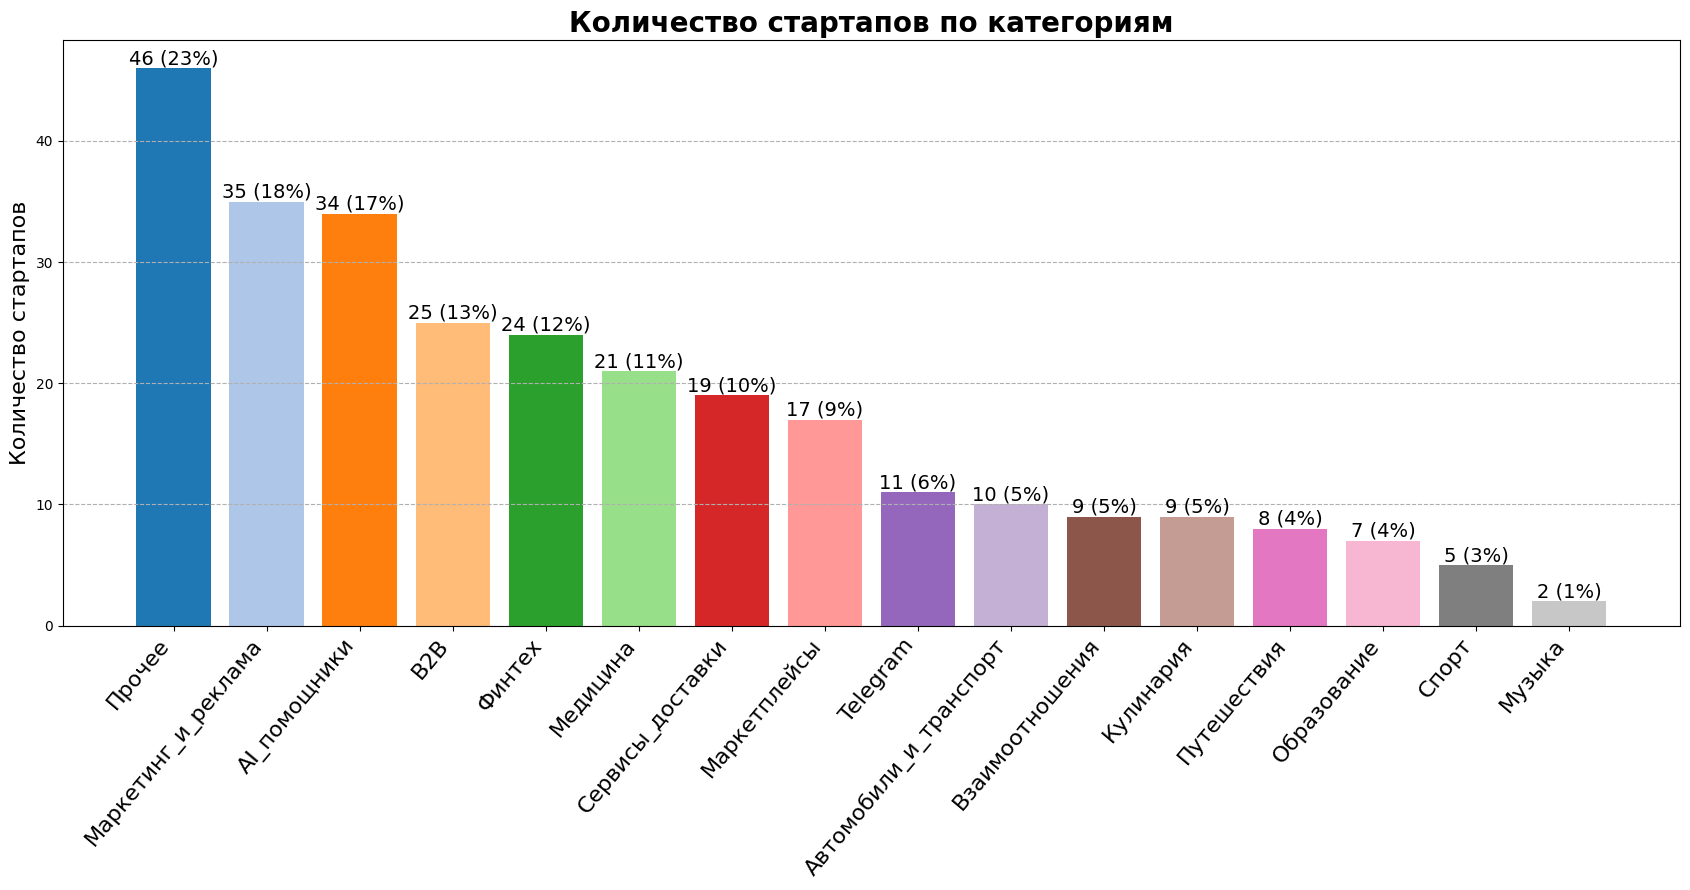

In [63]:
category_labels = list(subcategory_counts_df['Категория'])
category_counts = list(subcategory_counts_df['Количество'])
colors = plt.get_cmap('tab20').colors
total_counts = df.shape[0]
plt.figure(figsize=(17, 9))
bars = plt.bar(
    category_labels, 
    category_counts, 
    color=colors[:len(category_labels)]
)
plt.title('Количество стартапов по категориям', fontsize=20, fontweight='bold')
plt.ylabel('Количество стартапов', fontsize=16)
plt.xticks(rotation=50, fontsize=16, ha='right')  # Поворот меток категорий, если они длинные
plt.grid(axis='y', linestyle='--')  # Сетка по вертикальной оси
plt.tight_layout()  # Подгонка для отображения меток
for bar, count in zip(bars, category_counts):
    height = bar.get_height()
    # Рассчитываем процент
    percent = count / total_counts * 100
    # Отображаем количество и процент на графике
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        height, 
        f'{count} ({percent:.0f}%)', 
        ha='center', 
        va='bottom', 
        fontsize=14
    )
plt.show()



Видим, что распределение по заданным (предполагаемым) группам в основном сосредоточилось на маркетинге, рекламе и AI помощниках.

Это может быть связано с тем, что в настоящее время цифровые технологии применяются в любой области, что потверждается данными из массива уникальных подгрупп, почти в каждой из которых есть либо маркетинг с рекламой, либо AI

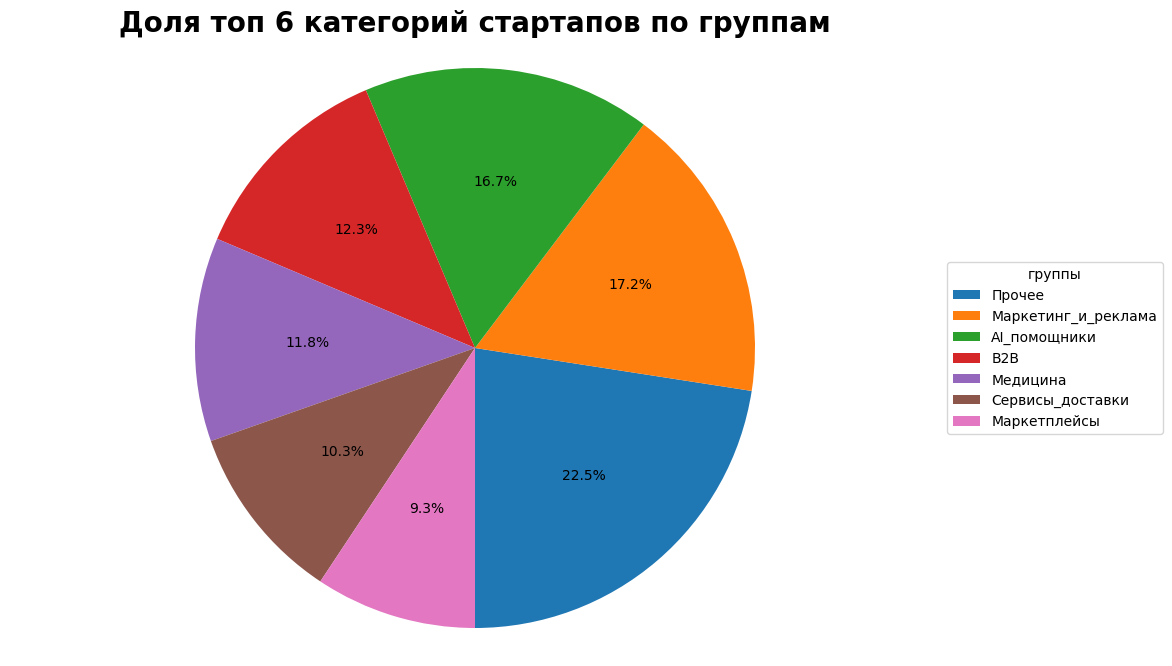

In [64]:

merge_to_other = ['Спорт', 'Музыка', 'Кулинария', 'Путешествия', 'Telegram', 'Взаимоотношения', 'Образование', 'Финтех', 'Автомобили_и_транспорт']
category_labels = list(subcategory_counts_df['Категория'])
category_counts = list(subcategory_counts_df['Количество'])
other_count = 0
for label, count in zip(category_labels, category_counts):
    if label in merge_to_other:
        other_count += count
category_labels = [label for label in category_labels if label not in merge_to_other]
category_counts = [count for label, count in zip(category_labels, category_counts) if label not in merge_to_other]
colors = plt.get_cmap('tab10').colors
plt.figure(figsize=(12, 8))
plt.pie(
    category_counts,
    autopct='%1.1f%%', 
    colors=colors[:len(category_labels)], 
    startangle=-90
)
plt.legend(
    category_labels,
    title="группы",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)
plt.title('Доля топ 6 категорий стартапов по группам', fontsize=20, fontweight='bold')
plt.axis('equal')  # Оформление диаграммы в круг
plt.show()



Заметим, что AI помощники ненамного отстают от макретинга и рекламы. Это связано с быстрым развитием искуственного интеллекта, поэтому сейчас все больше команд так или иначе используют AI в своих стартапах.

Логистические стартапы в свою очередь отстают от медицинских стартапов. Это можно объяснить тем, что в современном мире появилось очень много новых логистических услуг. Доставка продуктов из магазина, еды из ресторана, грузоперевозки от небольших шкафов до жилых домов. Все это является причиной достаточно большой доли логистических стартапов

Также стоит отметить, что чуть больше четверть всех проектов либо не попала ни в одну из категорий, либо же процент от общего числа составлял меньше 10 %  
Проанализировав эту категорию, можно сделать вывод, что в ней сосредоточились стартапы, которые либо "уникальны" в своем роде и их нельзя объединить с другими стартапами, либо категория будет настолько мала, что добавлять ее в список существующих нецелесообразно
